# 🎓 Stage 1 Flake Detection Tutorial

## Welcome to Computer Vision for Materials Science! 👋

This tutorial will teach you **step-by-step** how to detect MoS₂ flakes in optical microscopy images using Python and OpenCV.

### 🎯 What you'll learn:
- How to load and display microscopy images
- Basic image processing techniques (grayscale, thresholding, morphology)
- Contour detection and filtering
- Shape analysis (area, perimeter, solidity, etc.)
- How to identify valid flakes vs. noise/artifacts

### 📚 Prerequisites:
- Basic Python knowledge (variables, functions, loops)
- No prior computer vision experience needed!

### 🧪 What we're detecting:
MoS₂ (Molybdenum disulfide) flakes appear as **darker regions** in optical microscopy images because they absorb more light than the substrate.

---

## Step 1: Import Libraries and Setup 📦

First, let's import all the libraries we need for image processing and visualization.

In [1]:
# Import essential libraries for image processing
import cv2                    # OpenCV - the main computer vision library
import numpy as np            # NumPy - for numerical operations on image arrays
import matplotlib.pyplot as plt  # Matplotlib - for displaying images and plots
from pathlib import Path      # Path - for handling file paths easily
import warnings
warnings.filterwarnings('ignore')  # Hide warning messages for cleaner output

# Set up matplotlib for better image display
plt.rcParams['figure.figsize'] = (12, 8)  # Make figures larger by default
plt.rcParams['font.size'] = 12             # Larger text for better readability

print("✅ Libraries imported successfully!")
print(f"📊 OpenCV version: {cv2.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ Libraries imported successfully!
📊 OpenCV version: 4.12.0
🔢 NumPy version: 2.0.2


## Step 2: Load and Display the Original Image 🖼️

Let's start by loading a microscopy image and understanding what we're working with.

✅ Image found at: /content/Mo2C_20X-2025-10-21 14-45-14-899.png


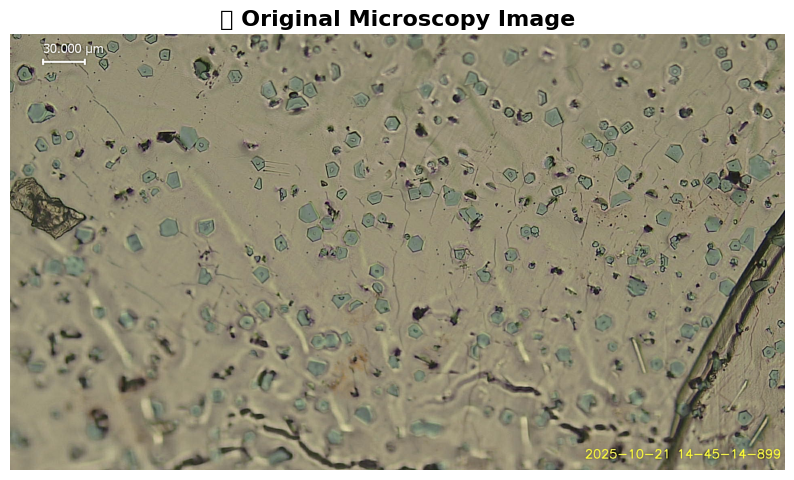


📏 Image dimensions: 1920 × 1080 pixels
🎨 Number of color channels: 3 (RGB)
📊 Image data type: uint8
🔢 Pixel value range: 0 to 255


In [2]:
# Define the path to your image
# Note: Change this path to point to your actual image file
image_path = "/content/Mo2C_20X-2025-10-21 14-45-14-899.png"

# Check if the image file exists
if not Path(image_path).exists():
    print(f"❌ Image not found at: {image_path}")
    print("Please update the image_path variable to point to your image file.")
else:
    print(f"✅ Image found at: {image_path}")

# Load the image using OpenCV
# cv2.imread() loads the image in BGR (Blue-Green-Red) format
img_bgr = cv2.imread(image_path)

# Convert from BGR to RGB format for proper display in matplotlib
# This is important because OpenCV uses BGR but matplotlib expects RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.title("📸 Original Microscopy Image", fontsize=16, fontweight='bold')
plt.axis('off')  # Hide axis numbers for cleaner display
plt.show()

# Print image information
height, width, channels = img_rgb.shape
print(f"\n📏 Image dimensions: {width} × {height} pixels")
print(f"🎨 Number of color channels: {channels} (RGB)")
print(f"📊 Image data type: {img_rgb.dtype}")
print(f"🔢 Pixel value range: {img_rgb.min()} to {img_rgb.max()}")

## Step 3: Convert to Grayscale 🖤

**Why grayscale?**
- Flake detection is based on **brightness differences**, not color
- Grayscale simplifies processing (1 channel instead of 3)
- Most computer vision algorithms work better on single-channel images

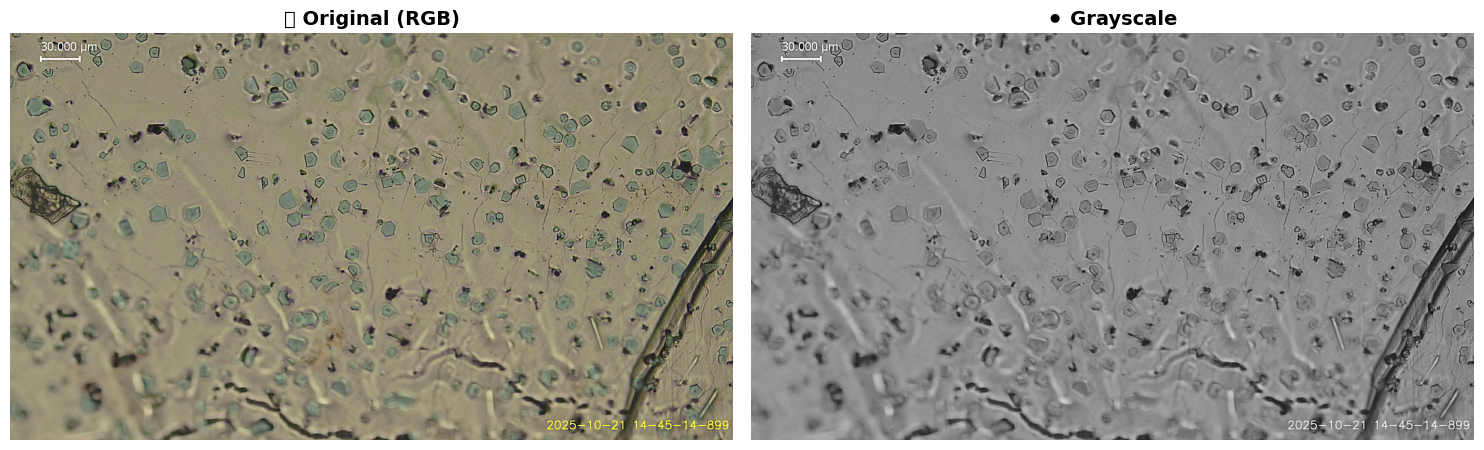


📊 Grayscale image statistics:
   Mean brightness: 134.1
   Standard deviation: 24.0
   Brightest pixel: 255
   Darkest pixel: 0


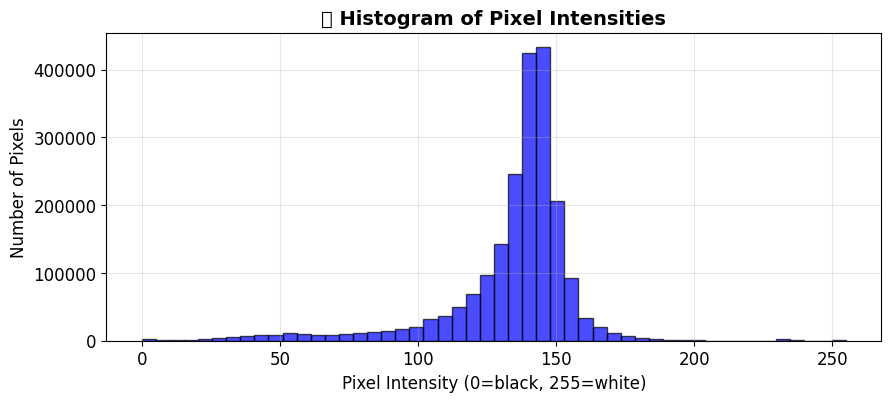


💡 Observation: Flakes appear as darker regions (lower pixel values) in the histogram.


In [3]:
# Convert the RGB image to grayscale
# This creates a single-channel image where each pixel represents brightness (0=black, 255=white)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Display both original and grayscale images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original image
axes[0].imshow(img_rgb)
axes[0].set_title("🌈 Original (RGB)", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Grayscale image
axes[1].imshow(gray, cmap='gray')  # cmap='gray' tells matplotlib to display in grayscale
axes[1].set_title("⚫ Grayscale", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Analyze the grayscale image
print(f"\n📊 Grayscale image statistics:")
print(f"   Mean brightness: {gray.mean():.1f}")
print(f"   Standard deviation: {gray.std():.1f}")
print(f"   Brightest pixel: {gray.max()}")
print(f"   Darkest pixel: {gray.min()}")

# Show histogram of pixel intensities
plt.figure(figsize=(10, 4))
plt.hist(gray.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("📈 Histogram of Pixel Intensities", fontsize=14, fontweight='bold')
plt.xlabel("Pixel Intensity (0=black, 255=white)")
plt.ylabel("Number of Pixels")
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 Observation: Flakes appear as darker regions (lower pixel values) in the histogram.")

## Step 4: Apply Thresholding 🎯

**Thresholding** converts our grayscale image into a **binary image** (only black and white pixels).

**The logic:**
- Pixels **darker** than threshold → White (255) in binary image → **Potential flakes**
- Pixels **brighter** than threshold → Black (0) in binary image → **Background/substrate**

🎯 Using intensity threshold: 140
   Pixels darker than 140 will be marked as potential flakes


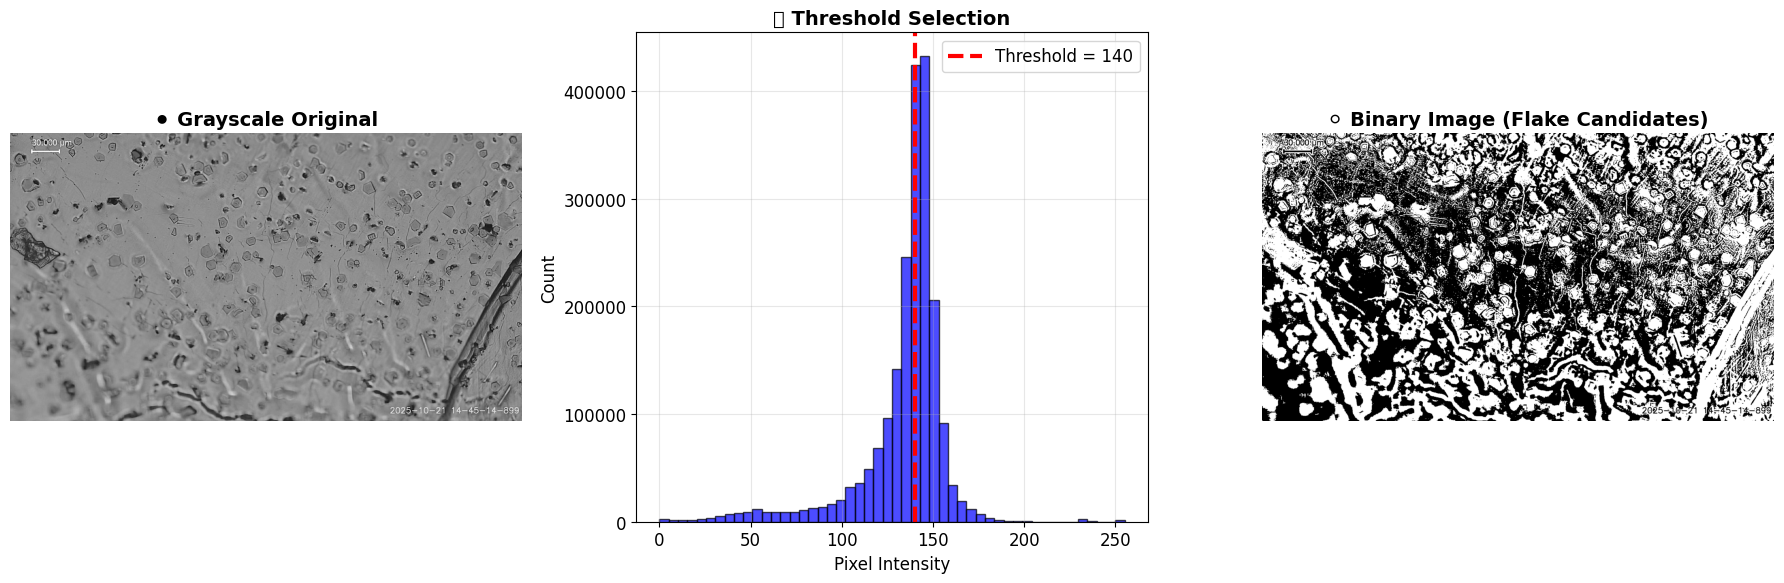


📊 Thresholding Results:
   Total pixels: 2,073,600
   Flake candidate pixels: 982,157
   Percentage of image identified as flakes: 47.36%

💡 White regions in the binary image are potential flake locations!


In [4]:
# Set the intensity threshold
# This value was optimized through experimentation - flakes are typically darker than 140
intensity_threshold = 140

print(f"🎯 Using intensity threshold: {intensity_threshold}")
print(f"   Pixels darker than {intensity_threshold} will be marked as potential flakes")

# Apply thresholding
# Create a boolean mask where True = darker than threshold
mask = gray < intensity_threshold

# Convert boolean mask to binary image (0 and 255)
binary = mask.astype(np.uint8) * 255

# Display the thresholding process
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original grayscale
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("⚫ Grayscale Original", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Show threshold line on histogram
axes[1].hist(gray.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1].axvline(x=intensity_threshold, color='red', linestyle='--', linewidth=3,
                label=f'Threshold = {intensity_threshold}')
axes[1].set_title("📈 Threshold Selection", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Pixel Intensity")
axes[1].set_ylabel("Count")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Binary result
axes[2].imshow(binary, cmap='gray')
axes[2].set_title("⚪ Binary Image (Flake Candidates)", fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Calculate statistics
flake_pixels = np.sum(binary > 0)
total_pixels = binary.size
flake_percentage = (flake_pixels / total_pixels) * 100

print(f"\n📊 Thresholding Results:")
print(f"   Total pixels: {total_pixels:,}")
print(f"   Flake candidate pixels: {flake_pixels:,}")
print(f"   Percentage of image identified as flakes: {flake_percentage:.2f}%")
print(f"\n💡 White regions in the binary image are potential flake locations!")

## Step 5: Morphological Operations - Cleaning Up 🧹

The binary image often contains **noise** (small unwanted white pixels). We use **morphological operations** to clean it up:

1. **Opening**: Removes small noise pixels
2. **Closing**: Fills small holes in flakes

🔧 Opening kernel size: 2×2 pixels
🔧 Closing kernel size: 4×4 pixels


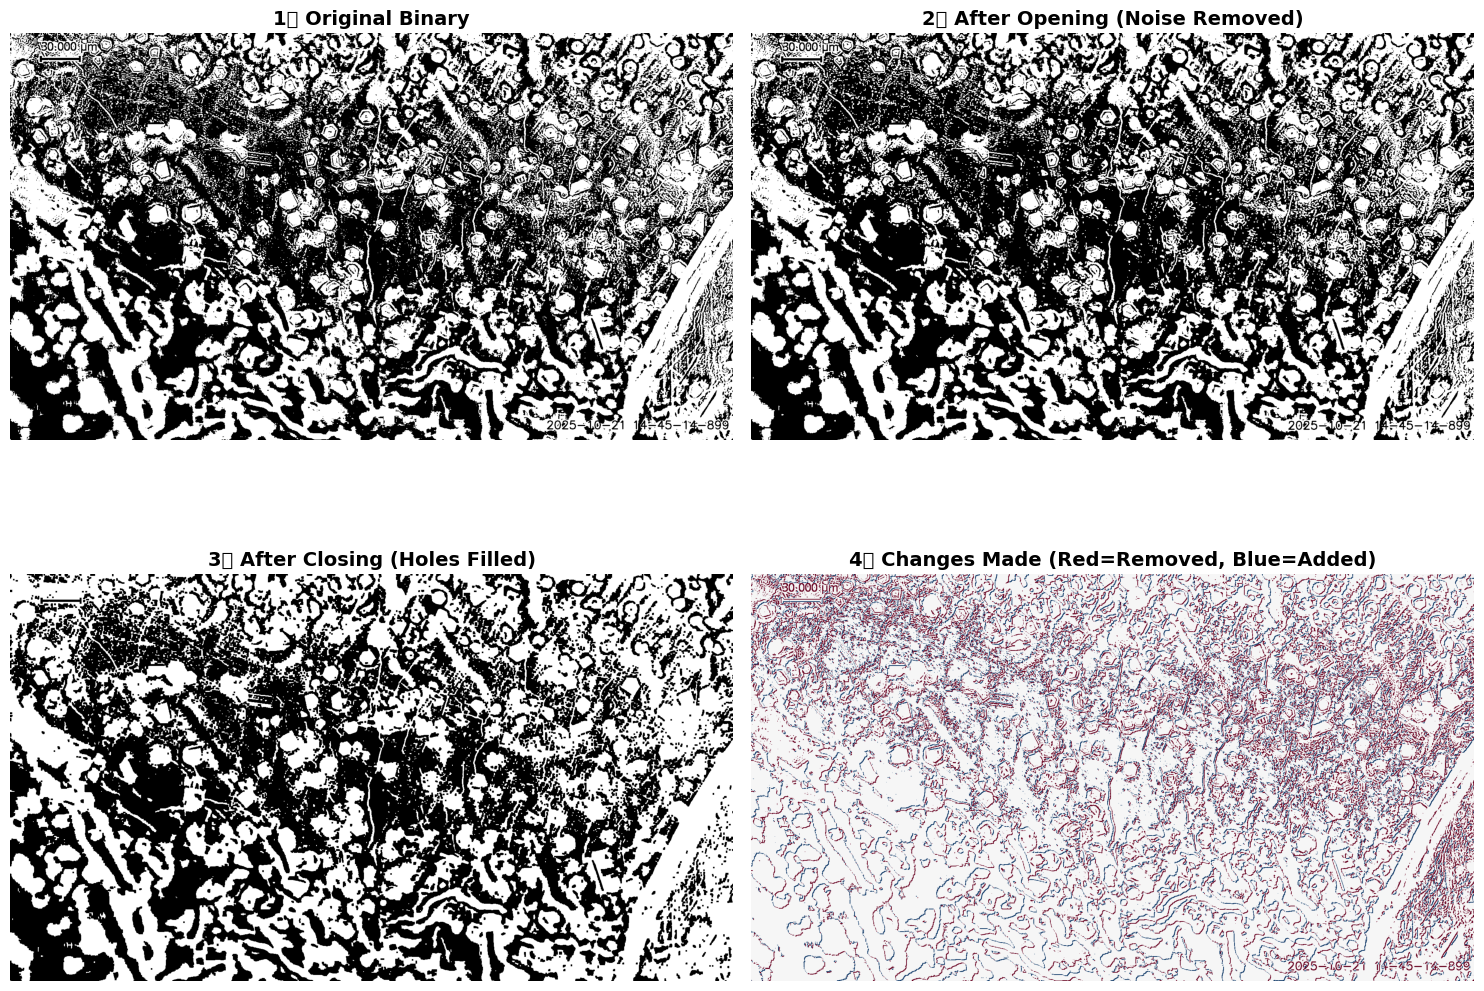


🧹 Morphological Cleaning Results:
   Pixels before cleaning: 982,157
   Pixels after cleaning: 1,070,098
   Net pixels removed: -87,941
   Percentage change: -8.95%

💡 Morphological operations help remove noise while preserving flake shapes!


In [5]:
# Create morphological kernels (structuring elements)
# These are small matrices that define the neighborhood for operations

# Small kernel for opening (removes tiny noise)
kernel_open = np.ones((2, 2), np.uint8)
print(f"🔧 Opening kernel size: 2×2 pixels")

# Larger kernel for closing (fills small gaps)
kernel_close = np.ones((4, 4), np.uint8)
print(f"🔧 Closing kernel size: 4×4 pixels")

# Apply morphological opening
# Opening = Erosion followed by Dilation
# This removes small white noise pixels
binary_opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open)

# Apply morphological closing
# Closing = Dilation followed by Erosion
# This fills small black holes inside white regions
binary_cleaned = cv2.morphologyEx(binary_opened, cv2.MORPH_CLOSE, kernel_close)

# Display the cleaning process
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original binary
axes[0, 0].imshow(binary, cmap='gray')
axes[0, 0].set_title("1️⃣ Original Binary", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# After opening
axes[0, 1].imshow(binary_opened, cmap='gray')
axes[0, 1].set_title("2️⃣ After Opening (Noise Removed)", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# After closing
axes[1, 0].imshow(binary_cleaned, cmap='gray')
axes[1, 0].set_title("3️⃣ After Closing (Holes Filled)", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Difference visualization
difference = binary.astype(int) - binary_cleaned.astype(int)
axes[1, 1].imshow(difference, cmap='RdBu', vmin=-255, vmax=255)
axes[1, 1].set_title("4️⃣ Changes Made (Red=Removed, Blue=Added)", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Calculate the effect of morphological operations
pixels_before = np.sum(binary > 0)
pixels_after = np.sum(binary_cleaned > 0)
pixels_removed = pixels_before - pixels_after

print(f"\n🧹 Morphological Cleaning Results:")
print(f"   Pixels before cleaning: {pixels_before:,}")
print(f"   Pixels after cleaning: {pixels_after:,}")
print(f"   Net pixels removed: {pixels_removed:,}")
print(f"   Percentage change: {(pixels_removed/pixels_before)*100:.2f}%")
print(f"\n💡 Morphological operations help remove noise while preserving flake shapes!")

## Step 6: Find Contours - Detecting Shapes 🔍

**Contours** are the boundaries of white regions in our binary image. Each contour represents a potential flake!

🔍 Found 1292 contours (potential flakes + noise)


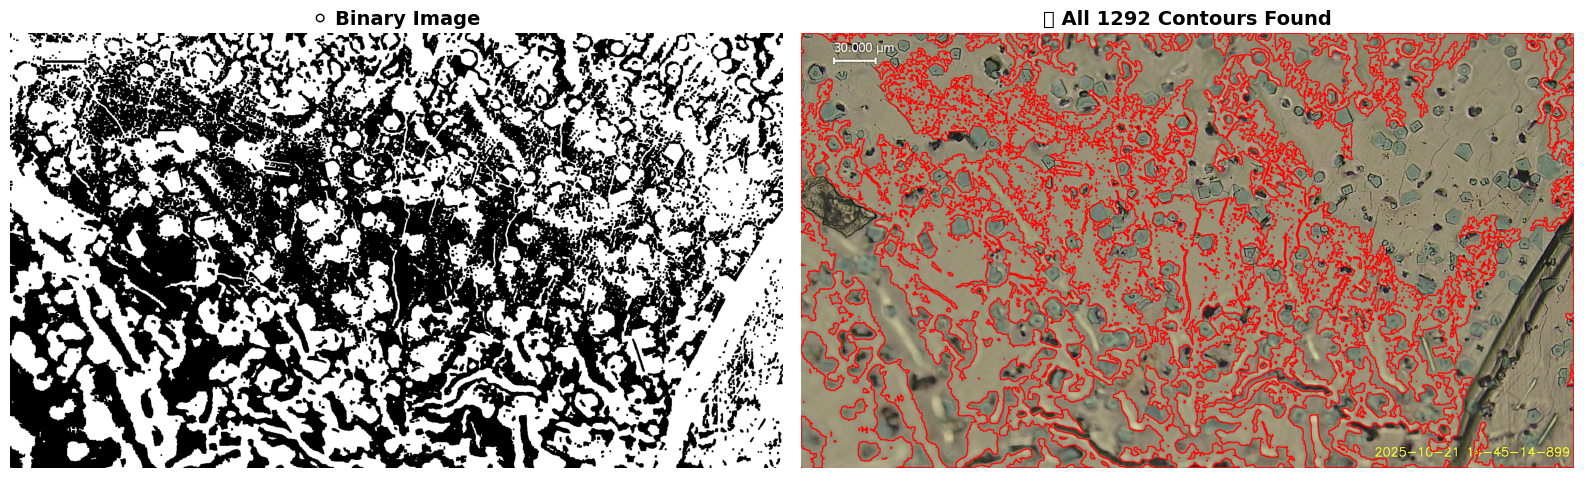


📊 Contour Area Statistics:
   Largest contour: 793402 pixels
   Smallest contour: 0 pixels
   Average area: 951 pixels
   Median area: 4 pixels


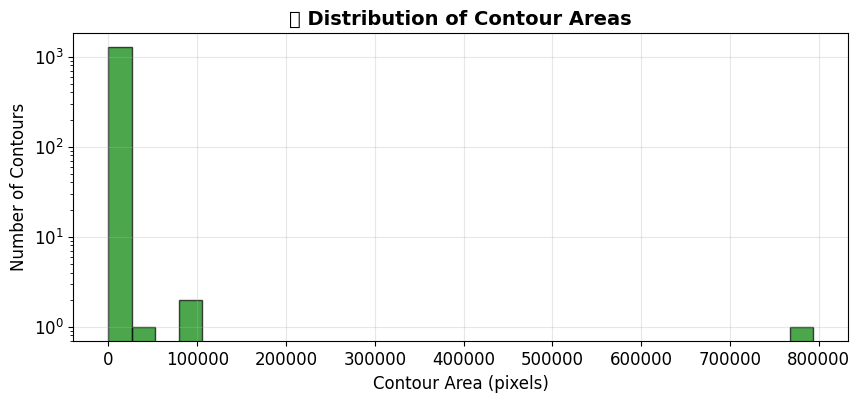


💡 Many contours are very small (noise). We need to filter them!


In [6]:
# Find contours in the cleaned binary image
# cv2.RETR_EXTERNAL: Only get outer contours (no holes)
# cv2.CHAIN_APPROX_SIMPLE: Compress contours to save memory
contours, hierarchy = cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"🔍 Found {len(contours)} contours (potential flakes + noise)")

# Create a copy of the original image to draw contours on
img_with_contours = img_rgb.copy()

# Draw ALL contours in red (before filtering)
cv2.drawContours(img_with_contours, contours, -1, (255, 0, 0), 2)

# Display original image with all contours
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Binary image
axes[0].imshow(binary_cleaned, cmap='gray')
axes[0].set_title(f"⚪ Binary Image", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Original with contours
axes[1].imshow(img_with_contours)
axes[1].set_title(f"🔴 All {len(contours)} Contours Found", fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Analyze contour sizes
contour_areas = [cv2.contourArea(contour) for contour in contours]
contour_areas.sort(reverse=True)

print(f"\n📊 Contour Area Statistics:")
print(f"   Largest contour: {contour_areas[0]:.0f} pixels")
print(f"   Smallest contour: {contour_areas[-1]:.0f} pixels")
print(f"   Average area: {np.mean(contour_areas):.0f} pixels")
print(f"   Median area: {np.median(contour_areas):.0f} pixels")

# Show histogram of contour areas
plt.figure(figsize=(10, 4))
plt.hist(contour_areas, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title("📈 Distribution of Contour Areas", fontsize=14, fontweight='bold')
plt.xlabel("Contour Area (pixels)")
plt.ylabel("Number of Contours")
plt.yscale('log')  # Log scale to see small contours better
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n💡 Many contours are very small (noise). We need to filter them!")

## Step 7: Filter Contours - Finding Real Flakes 🎯

Not all contours are flakes! We need to filter them based on:
1. **Size** (area): Too small = noise, too large = artifacts
2. **Shape properties**: Real flakes have certain geometric characteristics

🎯 Flake Size Filters:
   Minimum area: 200 pixels
   Maximum area: 15000 pixels

📊 Size Filtering Results:
   Too small: 1199 contours
   Too large: 6 contours
   Good size: 87 contours


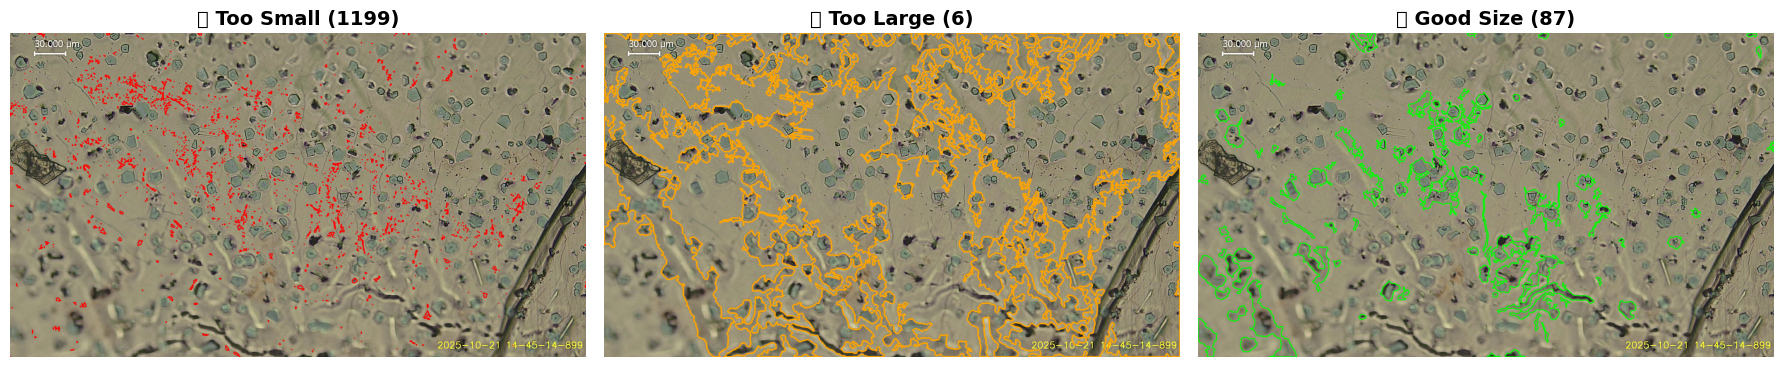


💡 Size filtering removed 1205 contours!


In [7]:
# Define size filters (same as in the main pipeline)
min_flake_area = 200    # Minimum area in pixels
max_flake_area = 15000  # Maximum area in pixels

print(f"🎯 Flake Size Filters:")
print(f"   Minimum area: {min_flake_area} pixels")
print(f"   Maximum area: {max_flake_area} pixels")

# Lists to store different types of contours
too_small = []      # Contours smaller than minimum
too_large = []      # Contours larger than maximum
size_filtered = []  # Contours within size range

# First pass: Filter by size only
for contour in contours:
    area = cv2.contourArea(contour)

    if area < min_flake_area:
        too_small.append(contour)
    elif area > max_flake_area:
        too_large.append(contour)
    else:
        size_filtered.append(contour)

print(f"\n📊 Size Filtering Results:")
print(f"   Too small: {len(too_small)} contours")
print(f"   Too large: {len(too_large)} contours")
print(f"   Good size: {len(size_filtered)} contours")

# Visualize size filtering
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create separate images for each category
img_small = img_rgb.copy()
img_large = img_rgb.copy()
img_good = img_rgb.copy()

# Draw contours in different colors
if too_small:
    cv2.drawContours(img_small, too_small, -1, (255, 0, 0), 2)  # Red for too small
if too_large:
    cv2.drawContours(img_large, too_large, -1, (255, 165, 0), 3)  # Orange for too large
if size_filtered:
    cv2.drawContours(img_good, size_filtered, -1, (0, 255, 0), 2)  # Green for good size

axes[0].imshow(img_small)
axes[0].set_title(f"🔴 Too Small ({len(too_small)})", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_large)
axes[1].set_title(f"🟠 Too Large ({len(too_large)})", fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(img_good)
axes[2].set_title(f"🟢 Good Size ({len(size_filtered)})", fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n💡 Size filtering removed {len(too_small) + len(too_large)} contours!")

## Step 8: Shape Analysis - The Science Behind Flake Detection 🔬

Real flakes have specific geometric properties. Let's analyze each shape candidate:

In [9]:
# Analyze shape properties for each size-filtered contour
flake_candidates = []
rejected_shapes = []

print(f"🔬 Analyzing {len(size_filtered)} shape candidates...\n")

for i, contour in enumerate(size_filtered):
    # Calculate basic geometric properties
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Skip if perimeter is zero (shouldn't happen, but safety check)
    if perimeter == 0:
        continue

    # 1. POLYGON APPROXIMATION
    # Simplify the contour to a polygon with fewer vertices
    epsilon = 0.02 * perimeter  # 2% of perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)
    vertices = len(approx)

    # 2. CONVEX HULL AND SOLIDITY
    # Solidity = ratio of contour area to its convex hull area
    # High solidity = shape is mostly convex (good for flakes)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    # 3. ASPECT RATIO
    # Ratio of width to height of bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 1

    # 4. CIRCULARITY
    # How close the shape is to a perfect circle
    # circularity = 4π × area / perimeter²
    circularity = 4 * np.pi * area / (perimeter * perimeter)

    # DECISION CRITERIA (same as main pipeline)
    is_valid_flake = (
        0.3 < solidity < 1.0 and      # Not too concave, not perfectly convex
        aspect_ratio < 5.0 and        # Not too elongated
        circularity > 0.15 and        # Not too irregular
        3 <= vertices <= 10           # Reasonable polygon complexity
    )

    # Calculate centroid for labeling
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00']) if M['m00'] != 0 else 0
    cy = int(M['m01']/M['m00']) if M['m00'] != 0 else 0

    # Store results
    shape_data = {
        'id': i + 1,
        'contour': contour,
        'area': area,
        'perimeter': perimeter,
        'vertices': vertices,
        'solidity': solidity,
        'aspect_ratio': aspect_ratio,
        'circularity': circularity,
        'centroid': (cx, cy),
        'bbox': (x, y, w, h),
        'is_valid': is_valid_flake
    }

    if is_valid_flake:
        flake_candidates.append(shape_data)
    else:
        rejected_shapes.append(shape_data)

    # Print detailed analysis for first few candidates
    if i < 5:
        status = "✅ VALID FLAKE" if is_valid_flake else "❌ REJECTED"
        print(f"Shape {i+1}: {status}")
        print(f"   Area: {area:.0f} px, Vertices: {vertices}")
        print(f"   Solidity: {solidity:.3f}, Aspect Ratio: {aspect_ratio:.2f}")
        print(f"   Circularity: {circularity:.3f}")
        if not is_valid_flake:
            # Explain why it was rejected
            reasons = []
            if not (0.3 < solidity < 1.0):
                reasons.append(f"solidity {solidity:.3f} outside [0.3, 1.0]")
            if not (aspect_ratio < 5.0):
                reasons.append(f"aspect ratio {aspect_ratio:.2f} >= 5.0")
            if not (circularity > 0.15):
                reasons.append(f"circularity {circularity:.3f} <= 0.15")
            if not (3 <= vertices <= 10):
                reasons.append(f"vertices {vertices} outside [3, 10]")
            print(f"   Rejection reasons: {'; '.join(reasons)}")
        print()

print(f"\n🏆 Final Results:")
print(f"   Valid flakes found: {len(flake_candidates)}")
print(f"   Shapes rejected: {len(rejected_shapes)}")
print(f"   Success rate: {len(flake_candidates)/(len(flake_candidates)+len(rejected_shapes))*100:.1f}%")

🔬 Analyzing 87 shape candidates...

Shape 1: ✅ VALID FLAKE
   Area: 214 px, Vertices: 5
   Solidity: 0.656, Aspect Ratio: 3.21
   Circularity: 0.249

Shape 2: ✅ VALID FLAKE
   Area: 817 px, Vertices: 6
   Solidity: 0.794, Aspect Ratio: 2.64
   Circularity: 0.369

Shape 3: ✅ VALID FLAKE
   Area: 1993 px, Vertices: 8
   Solidity: 0.935, Aspect Ratio: 1.12
   Circularity: 0.708

Shape 4: ✅ VALID FLAKE
   Area: 342 px, Vertices: 7
   Solidity: 0.531, Aspect Ratio: 2.64
   Circularity: 0.162

Shape 5: ✅ VALID FLAKE
   Area: 4402 px, Vertices: 7
   Solidity: 0.795, Aspect Ratio: 2.02
   Circularity: 0.312


🏆 Final Results:
   Valid flakes found: 38
   Shapes rejected: 49
   Success rate: 43.7%


## Step 9: Visualize Final Results 🎨

Let's see our final flake detection results with detailed annotations!

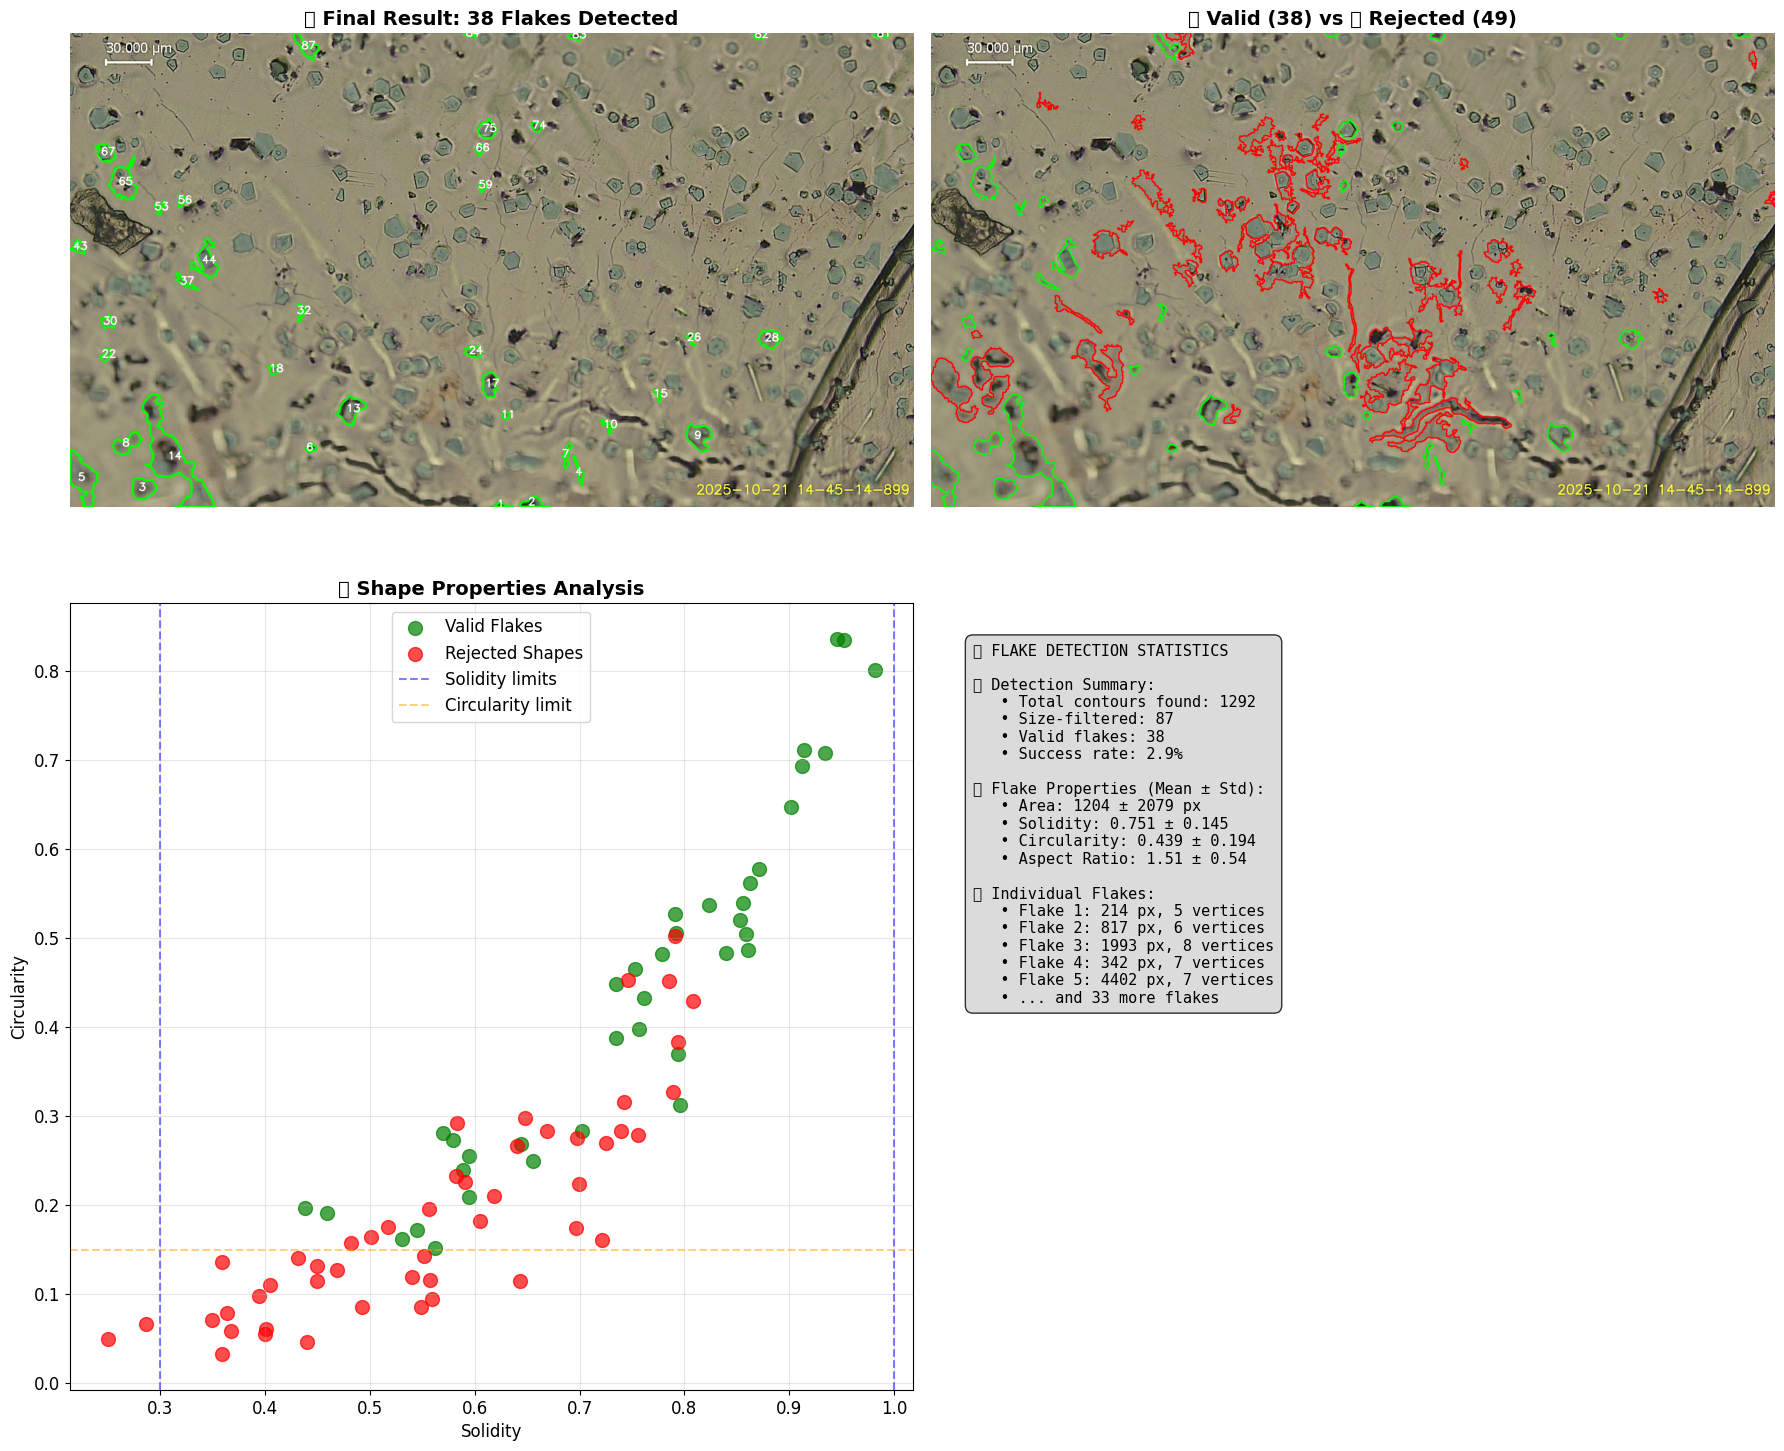


🎉 Stage 1 Flake Detection Complete!
Successfully detected 38 MoS₂ flakes in the image.


In [10]:
# Create visualization of final results
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# 1. Original image with valid flakes
img_final = img_rgb.copy()
for flake in flake_candidates:
    # Draw flake outline in green
    cv2.drawContours(img_final, [flake['contour']], -1, (0, 255, 0), 3)

    # Add flake ID label
    cx, cy = flake['centroid']
    cv2.putText(img_final, str(flake['id']), (cx-10, cy+5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

axes[0, 0].imshow(img_final)
axes[0, 0].set_title(f"🎯 Final Result: {len(flake_candidates)} Flakes Detected",
                     fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. Comparison: Valid vs Rejected
img_comparison = img_rgb.copy()
if flake_candidates:
    valid_contours = [f['contour'] for f in flake_candidates]
    cv2.drawContours(img_comparison, valid_contours, -1, (0, 255, 0), 2)  # Green for valid
if rejected_shapes:
    rejected_contours = [f['contour'] for f in rejected_shapes]
    cv2.drawContours(img_comparison, rejected_contours, -1, (255, 0, 0), 2)  # Red for rejected

axes[0, 1].imshow(img_comparison)
axes[0, 1].set_title(f"🟢 Valid ({len(flake_candidates)}) vs 🔴 Rejected ({len(rejected_shapes)})",
                     fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. Shape properties scatter plot
if flake_candidates:
    valid_solidity = [f['solidity'] for f in flake_candidates]
    valid_circularity = [f['circularity'] for f in flake_candidates]
    axes[1, 0].scatter(valid_solidity, valid_circularity, c='green', s=100,
                       alpha=0.7, label='Valid Flakes')

if rejected_shapes:
    rejected_solidity = [f['solidity'] for f in rejected_shapes]
    rejected_circularity = [f['circularity'] for f in rejected_shapes]
    axes[1, 0].scatter(rejected_solidity, rejected_circularity, c='red', s=100,
                       alpha=0.7, label='Rejected Shapes')

# Add decision boundaries
axes[1, 0].axvline(x=0.3, color='blue', linestyle='--', alpha=0.5, label='Solidity limits')
axes[1, 0].axvline(x=1.0, color='blue', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=0.15, color='orange', linestyle='--', alpha=0.5, label='Circularity limit')

axes[1, 0].set_xlabel('Solidity')
axes[1, 0].set_ylabel('Circularity')
axes[1, 0].set_title('📊 Shape Properties Analysis', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Flake statistics table
axes[1, 1].axis('off')
if flake_candidates:
    # Create a summary table
    areas = [f['area'] for f in flake_candidates]
    solidities = [f['solidity'] for f in flake_candidates]
    circularities = [f['circularity'] for f in flake_candidates]
    aspect_ratios = [f['aspect_ratio'] for f in flake_candidates]

    stats_text = f"""📋 FLAKE DETECTION STATISTICS

🎯 Detection Summary:
   • Total contours found: {len(contours)}
   • Size-filtered: {len(size_filtered)}
   • Valid flakes: {len(flake_candidates)}
   • Success rate: {len(flake_candidates)/len(contours)*100:.1f}%

📏 Flake Properties (Mean ± Std):
   • Area: {np.mean(areas):.0f} ± {np.std(areas):.0f} px
   • Solidity: {np.mean(solidities):.3f} ± {np.std(solidities):.3f}
   • Circularity: {np.mean(circularities):.3f} ± {np.std(circularities):.3f}
   • Aspect Ratio: {np.mean(aspect_ratios):.2f} ± {np.std(aspect_ratios):.2f}

🔍 Individual Flakes:"""

    for i, flake in enumerate(flake_candidates[:5]):  # Show first 5
        stats_text += f"\n   • Flake {flake['id']}: {flake['area']:.0f} px, {flake['vertices']} vertices"

    if len(flake_candidates) > 5:
        stats_text += f"\n   • ... and {len(flake_candidates)-5} more flakes"

    axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                     fontsize=11, verticalalignment='top', fontfamily='monospace',
                     bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
else:
    axes[1, 1].text(0.5, 0.5, "No valid flakes detected",
                     transform=axes[1, 1].transAxes, ha='center', va='center',
                     fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎉 Stage 1 Flake Detection Complete!")
print(f"Successfully detected {len(flake_candidates)} MoS₂ flakes in the image.")

## Step 10: Understanding the Parameters 🎛️

Let's explore how changing parameters affects detection results:

In [ ]:
# Function to test different thresholds
def test_threshold(threshold_value):
    """Test flake detection with a different intensity threshold"""
    # Apply new threshold
    test_binary = (gray < threshold_value).astype(np.uint8) * 255

    # Apply same morphological operations
    test_binary = cv2.morphologyEx(test_binary, cv2.MORPH_OPEN, kernel_open)
    test_binary = cv2.morphologyEx(test_binary, cv2.MORPH_CLOSE, kernel_close)

    # Find contours
    test_contours, _ = cv2.findContours(test_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count flakes with same criteria
    test_flakes = 0
    for contour in test_contours:
        area = cv2.contourArea(contour)
        if area < min_flake_area or area > max_flake_area:
            continue

        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        # Same shape analysis
        epsilon = 0.02 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 1
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if (0.3 < solidity < 1.0 and aspect_ratio < 5.0 and
            circularity > 0.15 and 3 <= len(approx) <= 10):
            test_flakes += 1

    return test_flakes, test_binary

# Test different threshold values
threshold_range = [120, 130, 140, 150, 160, 170]
flake_counts = []

print("🧪 Testing different intensity thresholds...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, threshold in enumerate(threshold_range):
    flake_count, test_binary = test_threshold(threshold)
    flake_counts.append(flake_count)

    # Display binary result
    axes[i].imshow(test_binary, cmap='gray')
    color = 'green' if threshold == intensity_threshold else 'red'
    marker = ' (CURRENT)' if threshold == intensity_threshold else ''
    axes[i].set_title(f"Threshold {threshold}: {flake_count} flakes{marker}",
                      fontsize=12, fontweight='bold', color=color)
    axes[i].axis('off')

    print(f"Threshold {threshold}: {flake_count} flakes detected")

plt.tight_layout()
plt.show()

# Plot threshold sensitivity
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, flake_counts, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=intensity_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Current threshold ({intensity_threshold})')
plt.xlabel('Intensity Threshold')
plt.ylabel('Number of Flakes Detected')
plt.title('📈 Threshold Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"\n💡 Observations:")
print(f"   • Lower thresholds detect more (potentially including noise)")
print(f"   • Higher thresholds detect fewer (potentially missing real flakes)")
print(f"   • Current threshold ({intensity_threshold}) is optimized for balance")

## 🎓 Tutorial Summary and Key Learnings

Congratulations! You've learned the complete Stage 1 flake detection pipeline. Here's what we accomplished:

### 🔍 **The Complete Pipeline:**

1. **📸 Image Loading**: Load and convert BGR→RGB for proper display
2. **⚫ Grayscale Conversion**: Simplify to single-channel brightness data
3. **🎯 Thresholding**: Separate dark flakes from bright background
4. **🧹 Morphological Cleaning**: Remove noise and fill holes
5. **🔍 Contour Detection**: Find shape boundaries
6. **📏 Size Filtering**: Remove too-small and too-large shapes
7. **🔬 Shape Analysis**: Check geometric properties
8. **✅ Validation**: Apply multiple criteria for flake identification

### 🧠 **Key Concepts You Mastered:**

- **Binary thresholding**: Converting continuous values to discrete decisions
- **Morphological operations**: Mathematical tools for shape manipulation
- **Contour analysis**: Understanding shape boundaries
- **Geometric descriptors**: Quantifying shape properties mathematically
- **Multi-criteria filtering**: Combining multiple tests for robust detection

### 🎛️ **Critical Parameters:**

| Parameter | Value | Purpose |
|-----------|-------|----------|
| `intensity_threshold` | 140 | Separates flakes from background |
| `min_flake_area` | 200 px | Removes small noise |
| `max_flake_area` | 15,000 px | Removes large artifacts |
| `solidity` | 0.3-1.0 | Shape convexity measure |
| `aspect_ratio` | <5.0 | Prevents overly elongated shapes |
| `circularity` | >0.15 | Ensures reasonable regularity |
| `vertices` | 3-10 | Polygon complexity bounds |

### 🚀 **Next Steps:**

Now that you understand Stage 1, you're ready to explore:
- **Stage 2**: Multilayer detection within flakes
- **Stage 3**: Twist angle calculation
- **Parameter optimization** for your specific images
- **Batch processing** multiple images

### 🛠️ **Practice Exercises:**

1. **Try different images**: Test this pipeline on your own microscopy data
2. **Parameter tuning**: Experiment with threshold values for your images
3. **Add new criteria**: Think of additional shape properties to filter flakes
4. **Visualization improvements**: Create custom overlays and annotations

### 📚 **Further Learning:**

- OpenCV documentation: https://docs.opencv.org/
- Image processing fundamentals
- Machine learning for computer vision
- Deep learning approaches to object detection

**Great job completing this tutorial! You now have a solid foundation in computer vision for materials science! 🎉**